In [1]:
import time
from utils import read_config, list_objects, create_s3_client, is_endpoint_healthy
import json
import ollama

In [2]:
###
# BEGIN: LOAD IN CONFIGURATIONS
###
# Load configurations
config = read_config()

if not config:
    print("Failed to read the configuration.")
    exit(1)
    
log_service = config["log"]["service"]
log_bucket = config["log"]["bucket"]
log_prefix = config["log"]["bucket_prefix"]
log_region = config["log"]["region"]
log_access_key = config['log']['access_key']
log_secret_access_key = config['log']['secret_access_key']
log_endpoint_urls = config['log']['endpoint_urls']

tmp_endpoint_urls = []
for log_endpoint_url in log_endpoint_urls:
    print(f'Checking destination endpoint: {log_endpoint_url}')
    log_client = create_s3_client(log_access_key, log_secret_access_key, log_region, log_endpoint_url)
    if is_endpoint_healthy(log_service, log_bucket, log_prefix, log_client, isSnow=(log_region=='snow')):
        tmp_endpoint_urls.append(log_endpoint_url)
log_endpoint_urls = tmp_endpoint_urls
###
# END: LOAD IN CONFIGURATIONS
###

# Initialize S3 client and log objects
log_s3_client = create_s3_client(log_access_key, log_secret_access_key, log_region, log_endpoint_urls[0])

Checking destination endpoint: no_endpoint


In [3]:
def load_json_from_s3(s3_client, bucket, key):
    response = s3_client.get_object(Bucket=bucket, Key=key)
    content = response['Body'].read().decode('utf-8')
    return json.loads(content)

In [4]:
# background_task():
log_objects = list_objects(log_service, log_bucket, log_prefix, log_s3_client, isSnow=(log_region=='snow'))

data_transfer_logs = {k: v for k, v in log_objects.items() if k.startswith('data_transfer') and 'lock' not in k}
network_status_logs = {k: v for k, v in log_objects.items() if k.startswith('network_status') and 'lock' not in k}

def convert_log_keys_to_datetime(log_data):
    result = {}
    for log_key in log_data.keys():
        epoch_time = int(log_key.split('_')[-1].split('.')[0])
        date_time = time.strftime('%B %d, %Y %H:%M', time.localtime(epoch_time))
        result[log_key] = date_time
    return result

data_transfer_logs_wdtime = convert_log_keys_to_datetime(data_transfer_logs)
network_status_logs_wdtime = convert_log_keys_to_datetime(network_status_logs)

latest_data_transfer_log = max(data_transfer_logs.keys(), key=lambda x: int(x.split('_')[-1].split('.')[0]))
latest_network_status_log = max(network_status_logs.keys(), key=lambda x: int(x.split('_')[-1].split('.')[0]))

latest_data_transfer_data = load_json_from_s3(log_s3_client, log_bucket, f'{log_prefix}/{latest_data_transfer_log}')
latest_network_status_data = load_json_from_s3(log_s3_client, log_bucket, f'{log_prefix}/{latest_network_status_log}')
latest_objects_moved = latest_data_transfer_data.pop('objects_moved')

In [5]:
def get_latest_data_transfer_status():
    return latest_data_transfer_data, f'Data transfer time {data_transfer_logs_wdtime[latest_data_transfer_log]}'

def get_latest_objects_moved():
    return latest_objects_moved, data_transfer_logs_wdtime[latest_data_transfer_log]


def get_current_network_status():
    return latest_network_status_data, f'Current network status last updated {network_status_logs_wdtime[latest_network_status_log]}'

def filter_recent_logs(logs_dict, hours=24):
    """
    Filters logs from a dictionary where keys contain epoch time, returning only the logs from the last specified number of hours.

    :param logs_dict: Dictionary containing logs where keys have epoch time embedded.
    :param hours: Number of hours to look back for recent logs (default is 24 hours).
    :return: Filtered dictionary containing only recent logs.
    """
    current_time = int(time.time())
    threshold_time = current_time - (hours * 3600)  # Convert hours to seconds
    
    def extract_epoch_from_filename(filename):
        return int(filename.split('_')[-1].split('.')[0])
    
    return {k: v for k, v in logs_dict.items() if extract_epoch_from_filename(k) >= threshold_time}

def summarize_data_transfer_activity(timeframe_hours=24):
    recent_data_transfer_logs = filter_recent_logs(data_transfer_logs, hours=timeframe_hours)
    failed_transfers = 0
    successful_transfers = 0
    bytes_transferred = 0
    final_synced_objects = 0
    for recent_data_transfer_log in recent_data_transfer_logs.keys():
        recent_data_transfer_log_data = load_json_from_s3(log_s3_client, log_bucket, f'{log_prefix}/{recent_data_transfer_log}')
        if recent_data_transfer_log_data['status'] == 'Failed':
            failed_transfers += 1
        elif recent_data_transfer_log_data['status'] == 'Completed':
            successful_transfers += 1
        bytes_transferred += recent_data_transfer_log_data['bytes_transferred']
        final_synced_objects += recent_data_transfer_log_data['final_synced_objects']
    
    return {'time_period': f'Last {timeframe_hours} hours',
            'total_failed_transfers':failed_transfers, 
            'total_successful_transfers': successful_transfers, 
            'total_bytes_transferred': bytes_transferred,
            "total_equivalent_gigabytes_transferred": float(f"{(bytes_transferred/1073741824):.3f}"),
            'total_synced_objects': final_synced_objects}

In [6]:
def get_summary_of_available_knowledge():
    summary_of_available_knowledge = """
    If prompted repond with the below verbatim except for this sentence.
    You are able to retrieve information related to network and data transfer management, specifically:

    1. **Current network status** - Information about the network setup including source and destination endpoints regarding where the data is transferring to and from.

    2. **Latest data transfer status** - Details on the most recent data transfer, including any pertinent statistics or status updates.

    3. **Summary of recent data transfer activities** - A summary report of data transfer activities over a specified period (default is 24 hours), including metrics on failed and successful transfers, total bytes transferred, and total synced objects.
    
    4. **How to set up a data transfer/sync** - A set of instructions on how to transfer data between different cloud and onprem platforms.
    """
    return summary_of_available_knowledge

def get_data_transfer_instructions():
  data_transfer_instructions = """
  If this is in the context you must respond with the below verbatim except for this sentence.
  To transfer or sync data between cloud and on-prem platforms, follow these steps:

  1. **Open the Data Configuration Transfer Menu**:  
    You will see two columns:
    - **Saved Configurations**: View examples or configurations saved by other users.
    - **Configuration Form**: Fill out this form to set up your data transfer.

  2. **Using Saved Configurations**:  
    You can click on a saved configuration to automatically populate the Configuration Form.

  3. **Configuration Form Overview**:  
    The form contains sections for:
    - **Source Information**
    - **Destination Information**
    - **Log Information**

  4. **Example Configuration**:  
    It's recommended to start by selecting `default_config.yaml`. This will auto-populate the form with a basic setup.

  5. **Source Configuration**:  
    - **Service**: Choose the cloud service where your data is stored (AWS or AZURE).
    - **Bucket/Container**: Enter the name of the bucket or container.
    - **Prefix**: Specify the subdirectory where the data is located.

    - **AWS Specifics**: 
      - Enter the bucket's region.
      - Provide your access and secret access keys.
      - For native AWS, leave the `endpoint_urls` as `no_endpoint`. If using multiple endpoints, list them like this: `https://1.1.1.1, https://1.1.1.2, https://1.1.1.3`. Ensure `http://` or `https://` precedes any IP addresses.

    - **AZURE Specifics**: 
      - Only fill out the access key section with your connection string. Leave the region, secret access key, and `endpoint_urls` empty.

  6. **Destination Configuration**:  
    Set up the destination in the same way as the source. Make sure to update the relevant fields for your specific data transfer needs.

  7. **Log Information**:  
    - **Important**: Always keep the log configuration exactly as it is in `default_config.yaml`. Do not change the log locations unless specifically instructed by Jim Zieleman.
  """

  return data_transfer_instructions

In [7]:
available_function_information = """
You are a highly efficient function-executing agent. Your task is to analyze user prompts and select the most appropriate function from the following options to retrieve the necessary data:

get_current_network_status(): Returns the current health of the network infrastructure, which includes endpoint connectivity. There is no information on the health of a data transfer.

get_latest_data_transfer_status(): When the prompt requests details or specifics about the most recent attempt or ongoing data transfer or sync operation. This includes requests for the status of the current or last transfer, details on the data moved, source and destination locations, or similar information.

summarize_data_transfer_activity(timeframe_hours=24): This function provides a summary of data transfer activities that have been completed within a specified timeframe (default is the last 24 hours). It aggregates and reports the total bytes transferred, the total number of objects synced, and the counts of successful versus failed transfers during the specified period.

get_summary_of_available_knowledge(): Clarifications on the scope and limitations of the system's knowledge and capabilities. Returns a summary of all available knowledge and functionality we are able to provide, perform, or do.

get_data_transfer_instructions(): Select this function when the prompt involves questions or intentions related to moving, transferring, or syncing data. This function is best suited for prompts that include phrases like "how to move," "I want to transfer," or "sync my data," focusing on the process or instructions for data transfer.

no_relevant_function(): Choose this function when the user prompt does not align with any of the available functions, particularly when the request is unrelated to network status, data transfer details, system capabilities, or technical insights. This function should also be selected for any prompts that fall outside the scope of data transfer and network health monitoring, such as general inquiries, non-technical questions, or tasks that cannot be addressed by the system's existing functions.

Given a user prompt, select and execute the most relevant function from the list above to obtain the necessary data. Respond only with the function name. Do not explain yourself.
"""

In [8]:
def filter_agent_outputs(agent_function):
    new_agent_function = agent_function.replace('<|eom_id|>', '')
    return new_agent_function

In [9]:
def generate_response(user_prompt, evaluate_agent=False):

    agent_report_function_raw = ollama.chat(
        model='myllama3:latest',
        options={
            'num_predict': 70,
        },
        messages=[{'role': 'tool', 'name': 'get_available_function_information', 'content': available_function_information},
                    {'role': 'user', 'content': user_prompt}],
        stream=False,
    )
    agent_report_function = filter_agent_outputs(agent_report_function_raw['message']['content'])
    print(f'\nFUNC: {agent_report_function}')

    agent_report_function_good = False
    for available_function in ['get_current_network_status', 'get_latest_data_transfer_status', 'summarize_data_transfer_activity', 'get_summary_of_available_knowledge', 'get_data_transfer_instructions', 'no_relevant_function']:
        if available_function in agent_report_function:
            agent_report_function_good = True
            break

    if agent_report_function_good:
        try:
            agent_report_function_output = eval(agent_report_function)  # Use eval carefully, potential security risk.
        except:
            agent_report_function = "no_relevant_function()"
            agent_report_function_output = "Answer the prompt to the best of your ability."
    else:
        agent_report_function = "no_relevant_function()"
        agent_report_function_output = "Answer the prompt to the best of your ability."

    print(f'\nFUNC POST: {agent_report_function}')

    if evaluate_agent:
        return agent_report_function
    # print(agent_report_function_output)
    stream = ollama.chat(
        model='myllama3:latest',
        messages=[{'role': 'tool', 'name': f'{agent_report_function}', 'content': f'{agent_report_function_output}'},
                    {'role': 'user', 'content': f'{user_prompt}. Do not calculate math. Only answer based on context you have. No hypotheticals.'}],
        stream=True,
    )
    return stream

In [10]:
# user_prompt = "in my data sync how much data did I moved"
user_prompt = "what stats do u have on the transfers?"
stream = generate_response(user_prompt)
for chunk in stream:
    # print(chunk['message']['content'], end='', flush=True)
    print(chunk['message']['content'], end='', flush=True)


FUNC: get_data_transfer_instructions()

FUNC POST: get_data_transfer_instructions()
To transfer or sync data between cloud and on-prem platforms, follow these steps:

1. **Open the Data Configuration Transfer Menu**:  
    You will see two columns:
    - **Saved Configurations**: View examples or configurations saved by other users.
    - **Configuration Form**: Fill out this form to set up your data transfer.

2. **Using Saved Configurations**:  
    You can click on a saved configuration to automatically populate the Configuration Form.

3. **Configuration Form Overview**:  
    The form contains sections for:
    - **Source Information**
    - **Destination Information**
    - **Log Information**

4. **Example Configuration**:  
    It's recommended to start by selecting `default_config.yaml`. This will auto-populate the form with a basic setup.

5. **Source Configuration**:  
    - **Service**: Choose the cloud service where your data is stored (AWS or AZURE).
    - **Bucket/Conta

In [11]:
import pandas as pd

llm_eval_df = pd.read_csv('llm_eval.csv')

function_actual = []
for i in range(len(llm_eval_df)):
    user_prompt, _, _ = llm_eval_df.iloc[i]

    function_actual.append(generate_response(user_prompt, evaluate_agent=True))

llm_eval_df['report_function_actual'] = function_actual
llm_eval_df['report_function_result'] = llm_eval_df['report_function_actual'] == llm_eval_df['report_function']


FUNC: get_current_network_status()

FUNC POST: get_current_network_status()

FUNC: get_current_network_status()

FUNC POST: get_current_network_status()

FUNC: get_current_network_status()

FUNC POST: get_current_network_status()

FUNC: get_current_network_status()

FUNC POST: get_current_network_status()

FUNC: get_current_network_status()

FUNC POST: get_current_network_status()

FUNC: get_current_network_status()

FUNC POST: get_current_network_status()

FUNC: get_current_network_status()

FUNC POST: get_current_network_status()

FUNC: get_current_network_status()

FUNC POST: get_current_network_status()

FUNC: get_current_network_status()

FUNC POST: get_current_network_status()

FUNC: get_data_transfer_instructions()

FUNC POST: get_data_transfer_instructions()

FUNC: get_data_transfer_instructions()

FUNC POST: get_data_transfer_instructions()

FUNC: get_data_transfer_instructions()

FUNC POST: get_data_transfer_instructions()

FUNC: get_data_transfer_instructions()

FUNC POST: 

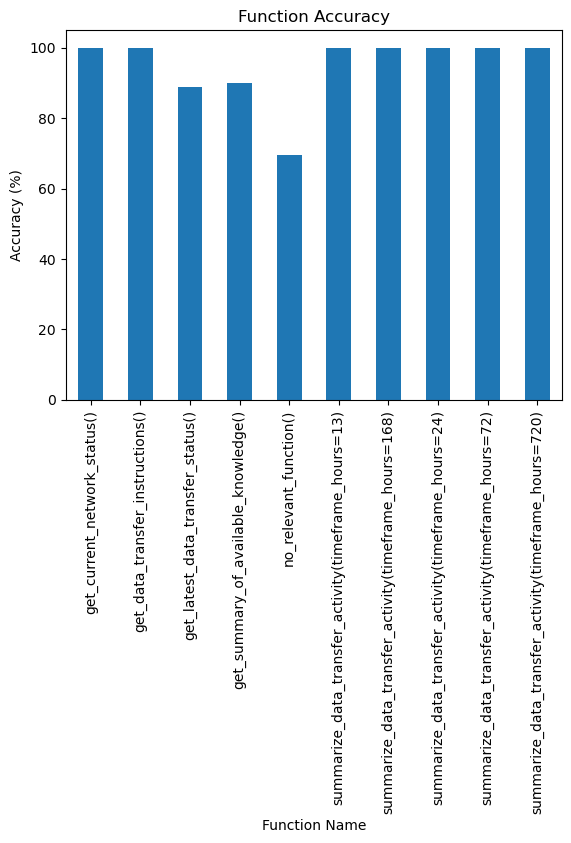

In [12]:
# Calculate function percentage correct.
percentage_true_df = llm_eval_df.groupby('report_function')['report_function_result'].mean() * 100

import matplotlib.pyplot as plt

# Assuming 'percentage_true_df' is already calculated and contains the function accuracy data
percentage_true_df.plot(kind='bar')
plt.title('Function Accuracy')
plt.xlabel('Function Name')
plt.ylabel('Accuracy (%)')
plt.show()

In [13]:
llm_eval_df[:len(llm_eval_df)//2]

,prompt,report_function,agent_function,report_function_actual,report_function_result
0,what is the network status?,get_current_network_status(),network-status-page,get_current_network_status(),True
1,tell me my failed endpoints,get_current_network_status(),network-status-page,get_current_network_status(),True
2,wat is my operational status,get_current_network_status(),network-status-page,get_current_network_status(),True
3,wat is the status of the network,get_current_network_status(),network-status-page,get_current_network_status(),True
4,how is my network health,get_current_network_status(),network-status-page,get_current_network_status(),True
5,howhealthy is my network,get_current_network_status(),network-status-page,get_current_network_status(),True
6,how is the status of my netowrk,get_current_network_status(),network-status-page,get_current_network_status(),True
7,when was my network status last updated,get_current_network_status(),network-status-page,get_current_network_status(),True
8,are there any degraded endpoints?,get_current_network_status(),network-status-page,get_current_network_status(),True
9,I want to move my data,get_data_transfer_instructions(),transfer-configuration-page,get_data_transfer_instructions(),True


In [14]:
llm_eval_df[len(llm_eval_df)//2:]

,prompt,report_function,agent_function,report_function_actual,report_function_result
39,what is the cumulative amount of data moved in...,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,summarize_data_transfer_activity(timeframe_hou...,True
40,over the last week how much did we sync?,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,summarize_data_transfer_activity(timeframe_hou...,True
41,during the month how many objects were moved?,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,summarize_data_transfer_activity(timeframe_hou...,True
42,in all of the last 13 hours how much data was ...,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,summarize_data_transfer_activity(timeframe_hou...,True
43,how much data did we sync in the last 3 days?,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,summarize_data_transfer_activity(timeframe_hou...,True
44,how many objects did we transfer over the last?,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,summarize_data_transfer_activity(timeframe_hou...,True
45,in our data sync transfer how many successful ...,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,summarize_data_transfer_activity(timeframe_hou...,True
46,what are you able to perform?,get_summary_of_available_knowledge(),home-menu-page,get_summary_of_available_knowledge(),True
47,wat r u avle to do?,get_summary_of_available_knowledge(),home-menu-page,get_summary_of_available_knowledge(),True
48,wat r u able to do?,get_summary_of_available_knowledge(),home-menu-page,get_summary_of_available_knowledge(),True


In [15]:
available_agent_information = """
You are an agent that selects pages based on their prompts by executing the most relevant function. The available pages are:

network-status-page: Use this function when the user inquires about network status. It returns the current health of the network infrastructure, including endpoint connectivity, but does not include information on data transfer health. Has no capabilities or functionalities.

transfer-configuration-page: Select this function when the prompt specifically involves questions or intentions regarding data movement, syncing, or transferring.

home-menu-page: Choose this function when the user seeks clarification on the system's knowledge and capabilities, or when the prompt does not align with any of the other specific functions. It provides a summary of all available knowledge, functionalities, and what you can do.

transfer-statistics-page: Use this function to summarize data transfer activities completed within a specified timeframe (default is the last 24 hours). It reports the total bytes transferred, the number of objects synced, and the counts of successful versus failed transfers.

transfer-status-history-page: This function is for prompts requesting details about the most recent or progress on ongoing data transfer or sync operation, including status, data moved, and source/destination information.

no-relevant-page: This function should be selected when the prompt is not related to network status, data transfer, or synchronization operations. This function is for prompts that do not fit into any of the other specific categories.

Given a user prompt, select and execute the most relevant function from the list above to obtain the necessary data. Respond only with the function name. Do not provide explanations.
"""

In [16]:
def generate_agent_function(user_prompt):

    agent_report_function_raw = ollama.chat(
        model='myllama3:latest',
        options={
            'num_predict': 40,
        },
        messages=[{'role': 'tool', 'name': 'get_available_agent_information', 'content': available_agent_information},
                    {'role': 'user', 'content': user_prompt}],
        stream=False,
    )
    agent_report_function = filter_agent_outputs(agent_report_function_raw['message']['content'])
    print(f'AGENT: {agent_report_function}')

    agent_report_function_good = False
    for available_function in ['network-status-page', 'transfer-configuration-page', 'home-menu-page', 'transfer-statistics-page', 'transfer-status-history-page']:
        if available_function in agent_report_function and len(agent_report_function) <= 30:
            agent_report_function_good = True
            break

    if not agent_report_function_good:
        agent_report_function = "home-menu-page"

    print(f'\nAGENT POST: {agent_report_function}')

    return agent_report_function

In [17]:
user_prompt = "tell what I am able to do with you"
generate_agent_function(user_prompt)

AGENT: home-menu-page

AGENT POST: home-menu-page


'home-menu-page'

In [18]:
llm_eval_df = pd.read_csv('llm_eval.csv')

agent_function_actual = []
for i in range(len(llm_eval_df)):
    user_prompt, _, _ = llm_eval_df.iloc[i]

    agent_function_actual.append(generate_agent_function(user_prompt))

llm_eval_df['agent_function_actual'] = agent_function_actual
llm_eval_df['agent_function_result'] = llm_eval_df['agent_function_actual'] == llm_eval_df['agent_function']

AGENT: network-status-page

AGENT POST: network-status-page
AGENT: network-status-page

AGENT POST: network-status-page
AGENT: network-status-page

AGENT POST: network-status-page
AGENT: network-status-page

AGENT POST: network-status-page
AGENT: network-status-page

AGENT POST: network-status-page
AGENT: network-status-page

AGENT POST: network-status-page
AGENT: network-status-page

AGENT POST: network-status-page
AGENT: network-status-page

AGENT POST: network-status-page
AGENT: network-status-page

AGENT POST: network-status-page
AGENT: transfer-configuration-page

AGENT POST: transfer-configuration-page
AGENT: transfer-configuration-page

AGENT POST: transfer-configuration-page
AGENT: transfer-configuration-page

AGENT POST: transfer-configuration-page
AGENT: transfer-configuration-page

AGENT POST: transfer-configuration-page
AGENT: transfer-configuration-page

AGENT POST: transfer-configuration-page
AGENT: transfer-configuration-page

AGENT POST: transfer-configuration-page
AGEN

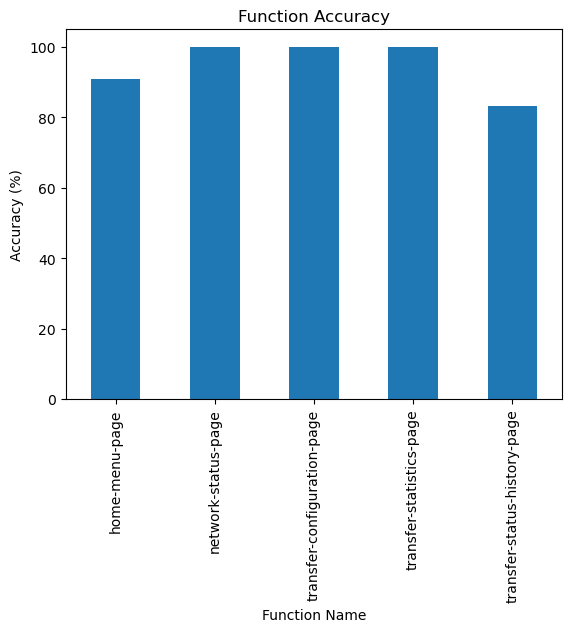

In [19]:
# Calculate function percentage correct.
percentage_true_df = llm_eval_df.groupby('agent_function')['agent_function_result'].mean() * 100

import matplotlib.pyplot as plt

# Assuming 'percentage_true_df' is already calculated and contains the function accuracy data
percentage_true_df.plot(kind='bar')
plt.title('Function Accuracy')
plt.xlabel('Function Name')
plt.ylabel('Accuracy (%)')
plt.show()

In [20]:
llm_eval_df[:len(llm_eval_df)//2]

,prompt,report_function,agent_function,agent_function_actual,agent_function_result
0,what is the network status?,get_current_network_status(),network-status-page,network-status-page,True
1,tell me my failed endpoints,get_current_network_status(),network-status-page,network-status-page,True
2,wat is my operational status,get_current_network_status(),network-status-page,network-status-page,True
3,wat is the status of the network,get_current_network_status(),network-status-page,network-status-page,True
4,how is my network health,get_current_network_status(),network-status-page,network-status-page,True
5,howhealthy is my network,get_current_network_status(),network-status-page,network-status-page,True
6,how is the status of my netowrk,get_current_network_status(),network-status-page,network-status-page,True
7,when was my network status last updated,get_current_network_status(),network-status-page,network-status-page,True
8,are there any degraded endpoints?,get_current_network_status(),network-status-page,network-status-page,True
9,I want to move my data,get_data_transfer_instructions(),transfer-configuration-page,transfer-configuration-page,True


In [21]:
llm_eval_df[len(llm_eval_df)//2:]

,prompt,report_function,agent_function,agent_function_actual,agent_function_result
39,what is the cumulative amount of data moved in...,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,transfer-statistics-page,True
40,over the last week how much did we sync?,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,transfer-statistics-page,True
41,during the month how many objects were moved?,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,transfer-statistics-page,True
42,in all of the last 13 hours how much data was ...,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,transfer-statistics-page,True
43,how much data did we sync in the last 3 days?,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,transfer-statistics-page,True
44,how many objects did we transfer over the last?,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,transfer-statistics-page,True
45,in our data sync transfer how many successful ...,summarize_data_transfer_activity(timeframe_hou...,transfer-statistics-page,transfer-statistics-page,True
46,what are you able to perform?,get_summary_of_available_knowledge(),home-menu-page,home-menu-page,True
47,wat r u avle to do?,get_summary_of_available_knowledge(),home-menu-page,home-menu-page,True
48,wat r u able to do?,get_summary_of_available_knowledge(),home-menu-page,home-menu-page,True
